# NeuralForceField with AuTopology priors

#### Here we show how to run NeuralForceField with classical fixed priors, and also learnable classical priors based on AuTopology.

We start off with imports:

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader


from nff.data import Dataset, split_train_validation_test
from nff.nn.modules import GraphDis
import pickle
from nff.data.loader import collate_dicts


from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
from plotting.utils import make_plot
import json
import pdb
import copy


The dataset we use below was generated in `data/create_dataset_from_file` in the usual way, but with a query ofn the database to generate the bond list, and an additional call to the command `generate_topologies()`.

In [2]:
dataset = Dataset.from_file("data/autopology_demonstration.pth.tar")

Below we'll want to compare many different targets and results, so we'll define a function `plot_overall` that plots energies and gradients vs. targets:

In [3]:
def plot_overall(results, targets):
    key_pairs = [["energy_0", "energy_0_grad"], ["energy_1", "energy_1_grad"]]
    make_plot(key_pairs, results, targets)


Clean out any old work and split the data into testing and training:

In [4]:
DEVICE = 2
OUTDIR = './sandbox'
BATCH_SIZE = 25
N_EPOCHS = 800

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)


train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

Create the model by setting the SchNet readout dictionary, and some other parameters related to the model. Note that if `trainable_prior` is True then the constants in the classical priors are functions of the atomic environment and can be learned. Otherwise they are set to a reasonable default value and not learned.

In [5]:
# number of features in the autopology feature vector
n_autopology_features = 256

autopology_params = {
    
    "n_features": n_autopology_features,
    "n_convolutions": 4,
    "conv_type": "double_node", # this type of convolution is a concatenation of features from
                                # both the node and the nodes it's bonded to. Another option is
                                # single_node, which doesn't use a concatenation

    
    # layers applied to the features after aggregating features of bonded nodes.
    # note that the first layer has 2*256 input features because here features are concatenated
    # after a convolution. If we'd used "conv_type" = "single_node" then the first layer
    # would have to have 256 input features
        
    "conv_update_layers": [{'name': 'linear', 'param' : {'in_features': int(2*n_autopology_features),
                                                    'out_features': n_autopology_features}},
                      {'name': 'Tanh', 'param': {}},
                      {'name': 'linear', 'param' : {'in_features': n_autopology_features,
                                              'out_features': n_autopology_features}},
                      {'name': 'Tanh', 'param': {}}


            ],
    
    
    "readout_hidden_nodes": [40, 20], # the number of nodes in each of the hidden layers 
                                      # of the readout network. The readout network acts on
                                      # the features after they have been convolved.
    
    # types of classical priors to use
    "bond_terms": ["morse"],
    "angle_terms": ["harmonic"],
    "dihedral_terms": ["OPLS"],
    "improper_terms": ["harmonic"],
    "pair_terms": [], # Lennard-Jones seems to be unstable, so leave out pairs for now
    
    
    # keys we're outputting 
    "output_keys": ["energy_0", "energy_1"],
    # whether we want the AuTopology weights to be learned
    "trainable_prior": True


}


n_atom_basis = 256

readoutdict = {
                    "energy_0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}],
                    "energy_1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}]
                }


schnet_params = {
    'n_atom_basis': n_atom_basis,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True,
    'readoutdict': readoutdict,    


}


# the combined set of parameters

params = {
    
    "autopology_params": autopology_params,
    "schnet_params": schnet_params,
    # output keys in order of ascending energy:
    "sorted_result_keys": ["energy_0", "energy_1"],
    "grad_keys": ["energy_0_grad", "energy_1_grad"],
    # whether or not to sort the results so that e0 < e1 < ...
    "sort_results": False,
    
}



We start the training by only generating AuTopology outputs, so that the model fits the data to classical priors as best as possible. Later we will freeze the AuTopology layers and add in the SchNet contribution.

In [6]:
model = get_model(params, model_type="SchNetAuTopology", add_autopology=True, add_schnet=False)

Let's look at how the combined model does and compare it to regular SchNet.

## I. Learnable AuTopology parameters. Combined AuTopology + SchNet output

We start the training in the usual way:

In [7]:
loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}
loss_fn = loss.build_mse_loss(loss_coef=loss_coef)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad'),

]


train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

# mini_batches is the number of times you update the loss for a given batch before taking a 
# step in the training. Here we have 25 molecules per batch but 2 mini batches, meaning our loss
# is based on data from 2 x 25 = 50 molecules.

T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [8]:
try:
    T.train(device=DEVICE, n_epochs=N_EPOCHS)
except Exception as e:
    print(e)
    pdb.post_mortem()

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-20 12:23:58 |     1 |     1.000e-04 |  7089.0806 |      10552.7293 |     158.4152 |           34.6104 |     135.5542 |           34.7511 |               0
2019-11-20 12:23:59 |     2 |     1.000e-04 |  5980.4417 |      10929.0734 |     161.6368 |           34.4144 |     143.0634 |           34.6924 |               0
2019-11-20 12:24:01 |     3 |     1.000e-04 |  5898.5777 |       9592.8420 |     123.7727 |           34.2842 |     120.3317 |           34.8319 |               0
2019-11-20 12:24:02 |     4 |     1.000e-04 |  5743.9432 |       9478.0775 |     140.8820 |           34.3783 |     124.1487 |           34.7756 |               0
2019-11-20 12:24:03 |     5 |     1.000e-04 |  5516.3524 |       9339.7037 |     137.9019 |           34.4017 |     124.4273 |           34.7474 |               0
2019-11-20 12:24:04 | 

2019-11-20 12:24:51 |    51 |     1.000e-04 |  3005.4099 |       4837.7816 |      96.5566 |           26.9533 |      84.1761 |           23.3104 |               0
2019-11-20 12:24:52 |    52 |     1.000e-04 |  3044.4593 |       4546.7858 |      85.9863 |           24.8517 |      80.3409 |           22.6861 |               0
2019-11-20 12:24:53 |    53 |     1.000e-04 |  2939.9185 |       4489.1719 |      83.9042 |           24.7950 |      73.3394 |           22.6020 |               0
2019-11-20 12:24:54 |    54 |     1.000e-04 |  2901.7536 |       4509.7053 |      86.2016 |           24.4139 |      82.0598 |           22.4876 |               0
2019-11-20 12:24:55 |    55 |     1.000e-04 |  2879.0918 |       4510.6135 |      87.9487 |           25.2293 |      79.4391 |           23.0848 |               0
2019-11-20 12:24:56 |    56 |     1.000e-04 |  2894.9798 |       4581.2874 |      95.8044 |           24.8728 |      78.9986 |           22.4967 |               0
2019-11-20 12:24:57 | 

2019-11-20 12:25:43 |   102 |     1.000e-04 |  2256.2450 |       3704.9467 |      75.9685 |           21.4356 |      67.2408 |           21.2941 |               0
2019-11-20 12:25:44 |   103 |     1.000e-04 |  2240.9353 |       3758.6949 |      81.1888 |           21.4600 |      69.0076 |           21.6733 |               0
2019-11-20 12:25:45 |   104 |     1.000e-04 |  2254.2869 |       3900.4729 |      84.2838 |           21.5656 |      77.0895 |           21.3665 |               0
2019-11-20 12:25:46 |   105 |     1.000e-04 |  2282.2448 |       3832.9008 |      83.9279 |           21.7268 |      71.8405 |           21.9694 |               0
2019-11-20 12:25:47 |   106 |     1.000e-04 |  2285.5398 |       3681.3356 |      76.2909 |           21.4283 |      68.8991 |           21.3588 |               0
2019-11-20 12:25:48 |   107 |     1.000e-04 |  2221.4162 |       3646.1002 |      71.0593 |           21.0379 |      62.0021 |           21.3579 |               0
2019-11-20 12:25:49 | 

2019-11-20 12:26:35 |   153 |     1.000e-04 |  1868.1851 |       3348.3753 |      70.9550 |           20.6324 |      63.5856 |           20.7829 |               0
2019-11-20 12:26:36 |   154 |     1.000e-04 |  1863.6674 |       3337.2778 |      69.5886 |           20.5838 |      64.8095 |           20.8146 |               0
2019-11-20 12:26:37 |   155 |     1.000e-04 |  1858.6438 |       3338.2822 |      70.5891 |           20.5891 |      64.1577 |           20.8573 |               0
2019-11-20 12:26:38 |   156 |     1.000e-04 |  1857.0088 |       3342.8988 |      70.3778 |           20.6922 |      64.8905 |           20.7624 |               0
2019-11-20 12:26:39 |   157 |     1.000e-04 |  1855.7474 |       3380.9017 |      72.5711 |           20.5826 |      65.0096 |           20.7896 |               0
2019-11-20 12:26:40 |   158 |     1.000e-04 |  1857.4794 |       3349.8310 |      69.9891 |           20.6742 |      66.2132 |           20.8072 |               0
2019-11-20 12:26:41 | 

2019-11-20 12:27:26 |   204 |     1.000e-04 |  1681.4393 |       3143.3184 |      66.1820 |           20.1265 |      63.4997 |           20.2075 |               0
2019-11-20 12:27:27 |   205 |     1.000e-04 |  1681.2391 |       3069.6091 |      64.5511 |           20.0803 |      58.0973 |           20.2695 |               0
2019-11-20 12:27:28 |   206 |     1.000e-04 |  1662.2940 |       3007.6987 |      57.9604 |           19.9846 |      55.4058 |           20.1591 |               0
2019-11-20 12:27:29 |   207 |     1.000e-04 |  1651.2720 |       3024.4222 |      61.1347 |           19.9427 |      52.1554 |           20.2055 |               0
2019-11-20 12:27:30 |   208 |     1.000e-04 |  1639.6796 |       3008.6206 |      58.2663 |           19.9716 |      54.7116 |           20.1512 |               0
2019-11-20 12:27:31 |   209 |     1.000e-04 |  1632.8266 |       3025.2533 |      59.7682 |           19.9531 |      55.8680 |           20.1671 |               0
2019-11-20 12:27:32 | 

2019-11-20 12:28:16 |   255 |     1.000e-04 |  1504.4104 |       2915.7991 |      64.1985 |           19.6976 |      52.4608 |           19.5993 |               0
2019-11-20 12:28:17 |   256 |     1.000e-04 |  1509.0990 |       2855.3068 |      57.2202 |           19.6264 |      51.8462 |           19.5790 |               0
2019-11-20 12:28:18 |   257 |     1.000e-04 |  1489.1720 |       2860.4723 |      55.2220 |           19.4348 |      53.0878 |           19.5769 |               0
2019-11-20 12:28:19 |   258 |     1.000e-04 |  1483.1622 |       2865.3703 |      52.2125 |           19.4338 |      54.2259 |           19.5793 |               0
2019-11-20 12:28:20 |   259 |     1.000e-04 |  1480.6832 |       2809.7561 |      54.3970 |           19.3609 |      51.1270 |           19.5697 |               0
2019-11-20 12:28:21 |   260 |     1.000e-04 |  1473.5661 |       2871.5743 |      59.4527 |           19.5701 |      51.7414 |           19.5604 |               0
2019-11-20 12:28:22 | 

2019-11-20 12:29:07 |   306 |     1.000e-04 |  1371.2288 |       2718.6249 |      54.3027 |           19.0360 |      54.2879 |           19.1515 |               0
2019-11-20 12:29:08 |   307 |     1.000e-04 |  1372.0338 |       2708.3389 |      55.2063 |           18.8811 |      51.0709 |           19.0502 |               0
2019-11-20 12:29:09 |   308 |     1.000e-04 |  1344.8084 |       2685.4510 |      53.7347 |           18.8606 |      44.2158 |           19.1096 |               0
2019-11-20 12:29:10 |   309 |     1.000e-04 |  1340.6931 |       2680.4611 |      49.7897 |           18.8927 |      46.2058 |           19.0871 |               0
2019-11-20 12:29:11 |   310 |     1.000e-04 |  1328.0398 |       2700.1333 |      50.9221 |           18.9937 |      49.5989 |           19.0120 |               0
2019-11-20 12:29:12 |   311 |     1.000e-04 |  1326.4836 |       2679.6982 |      52.0873 |           18.8430 |      51.0168 |           18.9908 |               0
2019-11-20 12:29:13 | 

2019-11-20 12:29:58 |   357 |     1.000e-04 |  1234.2145 |       2551.2954 |      56.3651 |           18.5211 |      46.2391 |           18.5628 |               0
2019-11-20 12:29:59 |   358 |     1.000e-04 |  1231.8275 |       2527.6864 |      51.9902 |           18.4272 |      45.0243 |           18.6045 |               0
2019-11-20 12:30:00 |   359 |     1.000e-04 |  1215.1716 |       2524.3951 |      47.8611 |           18.4759 |      45.4036 |           18.5833 |               0
2019-11-20 12:30:01 |   360 |     1.000e-04 |  1216.9475 |       2547.3882 |      47.1328 |           18.4791 |      47.5628 |           18.5661 |               0
2019-11-20 12:30:02 |   361 |     1.000e-04 |  1221.1090 |       2500.0543 |      46.9202 |           18.3438 |      46.7429 |           18.4837 |               0
2019-11-20 12:30:03 |   362 |     1.000e-04 |  1211.8064 |       2519.8663 |      51.9165 |           18.4179 |      44.9915 |           18.4741 |               0
2019-11-20 12:30:04 | 

2019-11-20 12:30:49 |   408 |     1.000e-04 |  1120.4859 |       2381.7496 |      45.2782 |           17.9956 |      43.9992 |           18.0590 |               0
2019-11-20 12:30:50 |   409 |     1.000e-04 |  1110.6369 |       2401.9872 |      49.4820 |           17.9108 |      44.1636 |           18.1439 |               0
2019-11-20 12:30:51 |   410 |     1.000e-04 |  1106.8362 |       2397.3301 |      51.4083 |           17.9922 |      44.8678 |           18.0549 |               0
2019-11-20 12:30:52 |   411 |     1.000e-04 |  1112.4186 |       2390.9195 |      50.2465 |           17.9545 |      47.5251 |           18.0866 |               0
2019-11-20 12:30:53 |   412 |     1.000e-04 |  1112.3910 |       2377.0205 |      47.1964 |           17.9485 |      48.8235 |           18.0799 |               0
2019-11-20 12:30:54 |   413 |     1.000e-04 |  1116.7681 |       2379.7162 |      45.8600 |           18.0003 |      47.7612 |           18.0414 |               0
2019-11-20 12:30:55 | 

2019-11-20 12:31:41 |   459 |     1.000e-04 |  1031.0658 |       2315.1217 |      50.8851 |           17.6619 |      46.8073 |           17.6839 |               0
2019-11-20 12:31:42 |   460 |     1.000e-04 |  1037.0363 |       2314.2090 |      49.6221 |           17.6425 |      48.7688 |           17.7143 |               0
2019-11-20 12:31:43 |   461 |     1.000e-04 |  1043.1359 |       2277.4981 |      46.5958 |           17.5892 |      46.7461 |           17.7487 |               0
2019-11-20 12:31:44 |   462 |     1.000e-04 |  1034.0348 |       2259.9155 |      44.8446 |           17.6773 |      38.4532 |           17.7154 |               0
2019-11-20 12:31:45 |   463 |     1.000e-04 |  1018.1188 |       2300.4546 |      44.0034 |           17.6812 |      38.7448 |           18.0796 |               0
2019-11-20 12:31:46 |   464 |     1.000e-04 |  1024.4575 |       2259.3377 |      43.8995 |           17.5318 |      41.8574 |           17.8181 |               0
2019-11-20 12:31:47 | 

2019-11-20 12:32:32 |   510 |     1.000e-04 |   954.3655 |       2227.3672 |      48.8006 |           17.1802 |      46.9409 |           17.3899 |               0
2019-11-20 12:32:33 |   511 |     1.000e-04 |   963.0873 |       2151.2449 |      44.7822 |           17.1665 |      41.3174 |           17.3642 |               0
2019-11-20 12:32:34 |   512 |     1.000e-04 |   949.9343 |       2169.2431 |      42.8222 |           17.2815 |      36.1865 |           17.5030 |               0
2019-11-20 12:32:35 |   513 |     1.000e-04 |   949.7932 |       2148.4918 |      42.9677 |           17.1985 |      38.2492 |           17.4118 |               0
2019-11-20 12:32:36 |   514 |     1.000e-04 |   943.8320 |       2196.0365 |      47.2346 |           17.1009 |      45.1442 |           17.3752 |               0
2019-11-20 12:32:37 |   515 |     1.000e-04 |   944.7168 |       2218.2002 |      49.0548 |           17.1486 |      46.3007 |           17.3456 |               0
2019-11-20 12:32:38 | 

2019-11-20 12:33:24 |   561 |     1.000e-04 |   882.9542 |       2078.9912 |      44.5025 |           16.7890 |      36.4537 |           17.1764 |               0
2019-11-20 12:33:25 |   562 |     1.000e-04 |   877.7859 |       2074.4495 |      45.8754 |           16.6738 |      40.2149 |           17.0516 |               0
2019-11-20 12:33:26 |   563 |     1.000e-04 |   878.3054 |       2095.6279 |      45.0393 |           16.7648 |      44.8499 |           17.0565 |               0
2019-11-20 12:33:27 |   564 |     1.000e-04 |   879.5033 |       2067.9482 |      43.6521 |           16.7803 |      43.2094 |           17.0540 |               0
2019-11-20 12:33:28 |   565 |     1.000e-04 |   881.4498 |       2050.3221 |      42.3789 |           16.8122 |      36.0774 |           17.1873 |               0
2019-11-20 12:33:29 |   566 |     1.000e-04 |   873.0454 |       2061.5027 |      42.2357 |           16.8295 |      35.6538 |           17.1290 |               0
2019-11-20 12:33:30 | 

2019-11-20 12:34:15 |   612 |     1.000e-04 |   797.6207 |       1938.5917 |      40.1723 |           16.4421 |      33.5015 |           16.7044 |               0
2019-11-20 12:34:16 |   613 |     1.000e-04 |   795.5347 |       1944.1667 |      40.1176 |           16.4036 |      33.7468 |           16.7588 |               0
2019-11-20 12:34:17 |   614 |     1.000e-04 |   796.2695 |       1945.9164 |      40.9604 |           16.3606 |      36.9915 |           16.6590 |               0
2019-11-20 12:34:18 |   615 |     1.000e-04 |   796.9145 |       1962.0096 |      41.7983 |           16.3485 |      40.9390 |           16.5702 |               0
2019-11-20 12:34:19 |   616 |     1.000e-04 |   798.1880 |       1972.8437 |      42.9236 |           16.3644 |      42.2449 |           16.5766 |               0
2019-11-20 12:34:20 |   617 |     1.000e-04 |   797.8496 |       1959.3455 |      43.6909 |           16.3712 |      39.9675 |           16.5923 |               0
2019-11-20 12:34:21 | 

2019-11-20 12:35:06 |   663 |     1.000e-04 |   746.4604 |       1880.6659 |      40.1862 |           16.0783 |      34.0171 |           16.4247 |               0
2019-11-20 12:35:07 |   664 |     1.000e-04 |   750.0844 |       1906.1736 |      40.6117 |           16.2388 |      32.6804 |           16.4999 |               0
2019-11-20 12:35:08 |   665 |     1.000e-04 |   754.0055 |       1862.1543 |      39.2618 |           16.1046 |      32.0464 |           16.4235 |               0
2019-11-20 12:35:09 |   666 |     1.000e-04 |   742.6490 |       1886.9596 |      44.2126 |           16.0037 |      35.2323 |           16.3341 |               0
2019-11-20 12:35:10 |   667 |     1.000e-04 |   744.7287 |       1922.0057 |      45.7288 |           16.0367 |      39.4064 |           16.3323 |               0
2019-11-20 12:35:11 |   668 |     1.000e-04 |   749.4424 |       1908.6117 |      41.0796 |           16.0801 |      41.4670 |           16.3341 |               0
2019-11-20 12:35:12 | 

2019-11-20 12:35:57 |   714 |     1.000e-04 |   695.8498 |       1802.1258 |      42.7094 |           15.7266 |      30.8557 |           16.0801 |               0
2019-11-20 12:35:58 |   715 |     1.000e-04 |   694.1901 |       1815.8851 |      42.2370 |           15.6626 |      36.3050 |           16.0667 |               0
2019-11-20 12:35:59 |   716 |     1.000e-04 |   699.6280 |       1801.1793 |      39.7081 |           15.7055 |      37.6534 |           16.0531 |               0
2019-11-20 12:36:00 |   717 |     1.000e-04 |   696.4766 |       1791.9561 |      37.2835 |           15.8162 |      32.0089 |           16.0497 |               0
2019-11-20 12:36:01 |   718 |     1.000e-04 |   687.5238 |       1800.7151 |      38.3783 |           15.8254 |      30.4515 |           16.0940 |               0
2019-11-20 12:36:02 |   719 |     1.000e-04 |   684.2297 |       1798.4950 |      40.9206 |           15.7076 |      30.7590 |           16.0864 |               0
2019-11-20 12:36:03 | 

2019-11-20 12:36:47 |   765 |     1.000e-04 |   642.3820 |       1727.0352 |      39.1759 |           15.4128 |      29.5868 |           15.7942 |               0
2019-11-20 12:36:48 |   766 |     1.000e-04 |   642.0314 |       1731.0416 |      36.3451 |           15.3809 |      34.3200 |           15.7502 |               0
2019-11-20 12:36:49 |   767 |     1.000e-04 |   640.1847 |       1736.0615 |      37.1159 |           15.4429 |      35.5480 |           15.7408 |               0
2019-11-20 12:36:50 |   768 |     1.000e-04 |   640.0093 |       1725.6489 |      37.9310 |           15.3887 |      32.8920 |           15.7401 |               0
2019-11-20 12:36:51 |   769 |     1.000e-04 |   636.8022 |       1732.4562 |      40.5134 |           15.3725 |      30.3376 |           15.7960 |               0
2019-11-20 12:36:52 |   770 |     1.000e-04 |   635.9949 |       1732.3269 |      41.1188 |           15.3851 |      29.3071 |           15.7563 |               0
2019-11-20 12:36:53 | 

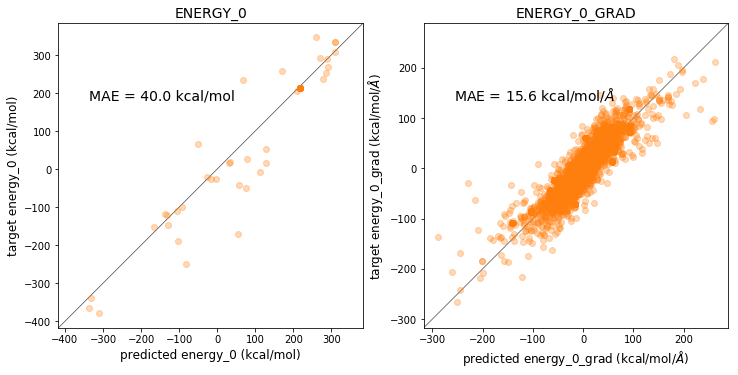

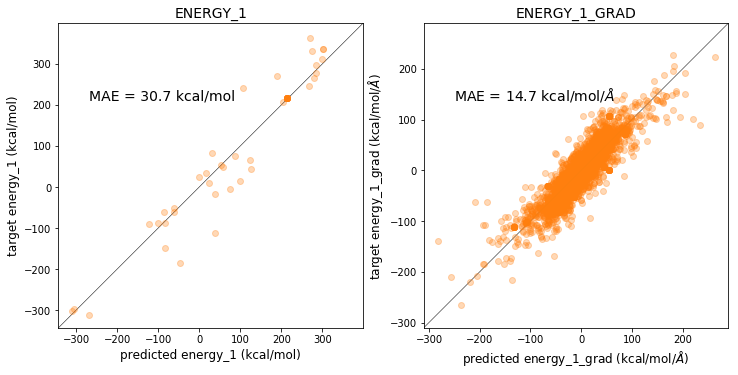

In [9]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

plot_overall(results, targets)

AuTopology is doing pretty well! Now we'll call the function `transfer_to_schnet`, which freezes the AuTopology parameters and adds the SchNet module to the output:

In [10]:
model.transfer_to_schnet()

Now we make a new trainer and train the new model, which itself contains a trained AuTopology force field and an un-trained SchNet model:

In [11]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)
    

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]



new_T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )



In [12]:
new_T.train(device=DEVICE, n_epochs=N_EPOCHS)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-20 12:37:24 |     1 |     1.000e-04 |   604.2468 |       1698.8765 |      37.6565 |           15.3675 |      29.8305 |           15.7175 |               0
2019-11-20 12:37:26 |     2 |     1.000e-04 |   592.8749 |       1720.1456 |      41.3769 |           15.3372 |      31.3026 |           15.6902 |               0
2019-11-20 12:37:27 |     3 |     1.000e-04 |   595.3050 |       1713.5325 |      40.4887 |           15.3030 |      30.7576 |           15.6632 |               0
2019-11-20 12:37:29 |     4 |     1.000e-04 |   589.8039 |       1703.3690 |      38.4463 |           15.2678 |      29.8139 |           15.6352 |               0
2019-11-20 12:37:30 |     5 |     1.000e-04 |   583.4307 |       1701.9686 |      37.2251 |           15.2299 |      29.4759 |           15.6027 |               0
2019-11-20 12:37:32 | 

2019-11-20 12:38:41 |    51 |     1.000e-04 |   317.9747 |       1177.6109 |      28.0304 |           12.1283 |      22.5602 |           12.7171 |               0
2019-11-20 12:38:43 |    52 |     1.000e-04 |   318.2106 |       1196.6574 |      30.0033 |           12.0863 |      24.2645 |           12.6874 |               0
2019-11-20 12:38:44 |    53 |     1.000e-04 |   321.8055 |       1225.4501 |      32.5791 |           12.0450 |      27.0238 |           12.6554 |               0
2019-11-20 12:38:46 |    54 |     1.000e-04 |   326.3810 |       1197.8050 |      30.9122 |           11.9845 |      25.1826 |           12.5937 |               0
2019-11-20 12:38:47 |    55 |     1.000e-04 |   317.7973 |       1124.0348 |      25.7513 |           11.9067 |      21.0061 |           12.5131 |               0
2019-11-20 12:38:49 |    56 |     1.000e-04 |   303.1583 |       1120.0514 |      27.6638 |           11.8488 |      21.8916 |           12.4678 |               0
2019-11-20 12:38:51 | 

2019-11-20 12:39:59 |   102 |     1.000e-04 |   216.6627 |        970.4300 |      21.8764 |           10.5878 |      17.1314 |           11.4510 |               0
2019-11-20 12:40:01 |   103 |     1.000e-04 |   218.0983 |        986.7689 |      23.7313 |           10.6017 |      18.8851 |           11.4574 |               0
2019-11-20 12:40:02 |   104 |     1.000e-04 |   220.6415 |        994.0889 |      24.5290 |           10.5967 |      20.0056 |           11.4493 |               0
2019-11-20 12:40:03 |   105 |     1.000e-04 |   220.9928 |        981.6539 |      23.5843 |           10.5729 |      18.8125 |           11.4274 |               0
2019-11-20 12:40:05 |   106 |     1.000e-04 |   217.3473 |        963.3829 |      21.8183 |           10.5349 |      16.8972 |           11.3977 |               0
2019-11-20 12:40:07 |   107 |     1.000e-04 |   212.2523 |        952.2158 |      21.1433 |           10.4975 |      16.5171 |           11.3708 |               0
2019-11-20 12:40:08 | 

2019-11-20 12:41:16 |   153 |     1.000e-04 |   179.7886 |        911.7002 |      22.0772 |            9.8954 |      18.5367 |           10.8348 |               0
2019-11-20 12:41:18 |   154 |     1.000e-04 |   177.7511 |        891.0132 |      20.3208 |            9.8787 |      16.0506 |           10.8200 |               0
2019-11-20 12:41:19 |   155 |     1.000e-04 |   173.7243 |        874.0829 |      18.9314 |            9.8686 |      14.3454 |           10.8154 |               0
2019-11-20 12:41:21 |   156 |     1.000e-04 |   170.5083 |        870.2171 |      20.1333 |            9.8569 |      15.5848 |           10.8134 |               0
2019-11-20 12:41:23 |   157 |     1.000e-04 |   169.7355 |        872.9008 |      21.7409 |            9.8379 |      16.7149 |           10.8014 |               0
2019-11-20 12:41:24 |   158 |     1.000e-04 |   170.0947 |        871.7408 |      21.5967 |            9.8128 |      16.6693 |           10.7808 |               0
2019-11-20 12:41:26 | 

2019-11-20 12:42:33 |   204 |     1.000e-04 |   150.5660 |        871.1882 |      22.4999 |            9.4418 |      19.3394 |           10.4276 |               0
2019-11-20 12:42:34 |   205 |     1.000e-04 |   152.9173 |        855.7412 |      20.8606 |            9.4279 |      17.7407 |           10.4129 |               0
2019-11-20 12:42:36 |   206 |     1.000e-04 |   150.4782 |        826.6533 |      17.6397 |            9.4159 |      13.6191 |           10.4031 |               0
2019-11-20 12:42:37 |   207 |     1.000e-04 |   145.4017 |        814.4316 |      17.7731 |            9.4115 |      13.5064 |           10.4041 |               0
2019-11-20 12:42:39 |   208 |     1.000e-04 |   143.4850 |        820.7148 |      20.4931 |            9.3965 |      15.6010 |           10.3987 |               0
2019-11-20 12:42:40 |   209 |     1.000e-04 |   145.2353 |        821.0779 |      20.6850 |            9.3651 |      15.8870 |           10.3725 |               0
2019-11-20 12:42:42 | 

2019-11-20 12:43:50 |   255 |     1.000e-04 |   130.1156 |        779.7509 |      15.4291 |            9.0804 |      11.6964 |           10.0718 |               0
2019-11-20 12:43:52 |   256 |     1.000e-04 |   125.1963 |        783.4321 |      18.8241 |            9.0750 |      14.3244 |           10.0738 |               0
2019-11-20 12:43:53 |   257 |     1.000e-04 |   126.8013 |        787.3922 |      19.8411 |            9.0482 |      15.3282 |           10.0564 |               0
2019-11-20 12:43:55 |   258 |     1.000e-04 |   128.4486 |        776.4682 |      16.8275 |            9.0206 |      12.7303 |           10.0324 |               0
2019-11-20 12:43:56 |   259 |     1.000e-04 |   125.8749 |        790.5215 |      16.8232 |            9.0377 |      13.2862 |           10.0407 |               0
2019-11-20 12:43:58 |   260 |     1.000e-04 |   126.0131 |        828.0975 |      21.4965 |            9.0623 |      18.4184 |           10.0563 |               0
2019-11-20 12:43:59 | 

2019-11-20 12:45:07 |   306 |     1.000e-04 |   111.7064 |        803.3864 |      21.0299 |            8.8314 |      17.8525 |            9.8134 |               0
2019-11-20 12:45:08 |   307 |     1.000e-04 |   116.5289 |        798.0891 |      20.4008 |            8.8204 |      17.2703 |            9.7959 |               0
2019-11-20 12:45:10 |   308 |     1.000e-04 |   116.1984 |        761.9105 |      15.3607 |            8.8032 |      12.0788 |            9.7721 |               0
2019-11-20 12:45:11 |   309 |     1.000e-04 |   110.4175 |        749.2662 |      15.9024 |            8.8041 |      11.9841 |            9.7728 |               0
2019-11-20 12:45:13 |   310 |     1.000e-04 |   109.1152 |        758.7977 |      18.5990 |            8.7937 |      14.4409 |            9.7728 |               0
2019-11-20 12:45:14 |   311 |     1.000e-04 |   112.2073 |        752.8317 |      17.3507 |            8.7626 |      13.3005 |            9.7547 |               0
2019-11-20 12:45:16 | 

2019-11-20 12:46:24 |   357 |     1.000e-04 |    98.1925 |        751.7090 |      16.2381 |            8.6049 |      13.2146 |            9.5753 |               0
2019-11-20 12:46:25 |   358 |     1.000e-04 |    99.0878 |        782.3888 |      20.5524 |            8.6232 |      17.2396 |            9.5866 |               0
2019-11-20 12:46:27 |   359 |     1.000e-04 |   103.4063 |        767.4633 |      18.5428 |            8.6077 |      15.4220 |            9.5641 |               0
2019-11-20 12:46:28 |   360 |     1.000e-04 |   101.5960 |        734.4335 |      13.5605 |            8.5899 |      10.2467 |            9.5448 |               0
2019-11-20 12:46:29 |   361 |     1.000e-04 |    96.6582 |        731.4842 |      16.0944 |            8.5974 |      12.1445 |            9.5524 |               0
2019-11-20 12:46:31 |   362 |     1.000e-04 |    97.6845 |        738.7295 |      17.7098 |            8.5856 |      13.8064 |            9.5476 |               0
2019-11-20 12:46:32 | 

2019-11-20 12:47:40 |   408 |     1.000e-04 |    87.3987 |        751.9552 |      18.1411 |            8.4524 |      14.9095 |            9.4138 |               0
2019-11-20 12:47:42 |   409 |     1.000e-04 |    90.5546 |        763.7136 |      19.6962 |            8.4545 |      16.3551 |            9.4076 |               0
2019-11-20 12:47:43 |   410 |     1.000e-04 |    92.6335 |        733.4715 |      15.1508 |            8.4326 |      12.1469 |            9.3835 |               0
2019-11-20 12:47:45 |   411 |     1.000e-04 |    88.3440 |        714.3782 |      13.8277 |            8.4297 |      10.2948 |            9.3846 |               0
2019-11-20 12:47:46 |   412 |     1.000e-04 |    86.4143 |        722.2392 |      16.7069 |            8.4327 |      12.8542 |            9.3913 |               0
2019-11-20 12:47:48 |   413 |     1.000e-04 |    89.7057 |        719.0584 |      16.0443 |            8.4066 |      12.2339 |            9.3759 |               0
2019-11-20 12:47:49 | 

2019-11-20 12:48:57 |   459 |     1.000e-04 |    83.2066 |        741.5927 |      17.8373 |            8.3100 |      14.6350 |            9.2655 |               0
2019-11-20 12:48:58 |   460 |     1.000e-04 |    82.4884 |        710.2176 |      12.7598 |            8.2930 |       9.5374 |            9.2521 |               0
2019-11-20 12:49:00 |   461 |     1.000e-04 |    78.2074 |        705.8951 |      14.8859 |            8.3029 |      11.0856 |            9.2591 |               0
2019-11-20 12:49:01 |   462 |     1.000e-04 |    79.4496 |        712.1827 |      16.4107 |            8.2903 |      12.6236 |            9.2547 |               0
2019-11-20 12:49:03 |   463 |     1.000e-04 |    82.0680 |        703.2613 |      13.9380 |            8.2666 |      10.3112 |            9.2369 |               0
2019-11-20 12:49:04 |   464 |     1.000e-04 |    79.3313 |        715.5683 |      13.9678 |            8.2801 |      10.8163 |            9.2453 |               0
2019-11-20 12:49:06 | 

2019-11-20 12:50:13 |   510 |     1.000e-04 |    70.8017 |        699.4151 |      14.9731 |            8.1884 |      11.2038 |            9.1423 |               0
2019-11-20 12:50:14 |   511 |     1.000e-04 |    73.0528 |        702.8323 |      15.7975 |            8.1759 |      12.0418 |            9.1341 |               0
2019-11-20 12:50:16 |   512 |     1.000e-04 |    74.8488 |        694.8044 |      12.8362 |            8.1560 |       9.3989 |            9.1148 |               0
2019-11-20 12:50:17 |   513 |     1.000e-04 |    71.6685 |        714.4893 |      14.8783 |            8.1742 |      11.6521 |            9.1283 |               0
2019-11-20 12:50:19 |   514 |     1.000e-04 |    71.7496 |        741.3242 |      18.8906 |            8.1959 |      15.4764 |            9.1398 |               0
2019-11-20 12:50:20 |   515 |     1.000e-04 |    75.1890 |        724.5453 |      16.3981 |            8.1750 |      13.2160 |            9.1238 |               0
2019-11-20 12:50:22 | 

2019-11-20 12:51:29 |   561 |     1.000e-04 |    66.1734 |        703.1205 |      13.6660 |            8.0688 |      10.4472 |            9.0153 |               0
2019-11-20 12:51:30 |   562 |     1.000e-04 |    65.1738 |        732.8082 |      18.3908 |            8.0949 |      14.9682 |            9.0358 |               0
2019-11-20 12:51:32 |   563 |     1.000e-04 |    68.6048 |        722.4523 |      16.8045 |            8.0766 |      13.5743 |            9.0206 |               0
2019-11-20 12:51:33 |   564 |     1.000e-04 |    67.5028 |        693.4869 |      11.9785 |            8.0547 |       8.6445 |            9.0112 |               0
2019-11-20 12:51:35 |   565 |     1.000e-04 |    63.8692 |        692.2449 |      14.4950 |            8.0704 |      10.8208 |            9.0193 |               0
2019-11-20 12:51:36 |   566 |     1.000e-04 |    65.9511 |        695.8812 |      15.4139 |            8.0646 |      11.7924 |            9.0107 |               0
2019-11-20 12:51:38 | 

2019-11-20 12:52:45 |   612 |     1.000e-04 |    60.1677 |        685.2206 |      12.5144 |            7.9683 |       9.1164 |            8.9177 |               0
2019-11-20 12:52:46 |   613 |     1.000e-04 |    58.8501 |        691.4007 |      15.1811 |            7.9880 |      11.5925 |            8.9223 |               0
2019-11-20 12:52:48 |   614 |     1.000e-04 |    62.1840 |        687.4050 |      14.0674 |            7.9673 |      10.6747 |            8.9023 |               0
2019-11-20 12:52:49 |   615 |     1.000e-04 |    61.3920 |        689.3660 |      11.9287 |            7.9632 |       8.4934 |            8.8920 |               0
2019-11-20 12:52:51 |   616 |     1.000e-04 |    58.7652 |        719.7085 |      17.1032 |            7.9910 |      13.7571 |            8.9171 |               0
2019-11-20 12:52:52 |   617 |     1.000e-04 |    61.3768 |        724.9722 |      17.7715 |            7.9906 |      14.4458 |            8.9171 |               0
2019-11-20 12:52:54 | 

2019-11-20 12:54:02 |   663 |     1.000e-04 |    54.1842 |        716.8844 |      17.0522 |            7.9182 |      13.7259 |            8.8272 |               0
2019-11-20 12:54:03 |   664 |     1.000e-04 |    56.8364 |        720.2133 |      17.4686 |            7.9135 |      14.1683 |            8.8267 |               0
2019-11-20 12:54:05 |   665 |     1.000e-04 |    57.5998 |        690.8553 |      12.4108 |            7.8833 |       9.2450 |            8.8080 |               0
2019-11-20 12:54:07 |   666 |     1.000e-04 |    53.8043 |        682.6017 |      13.2462 |            7.8953 |       9.9336 |            8.8189 |               0
2019-11-20 12:54:08 |   667 |     1.000e-04 |    54.5585 |        688.2163 |      15.0463 |            7.9044 |      11.6202 |            8.8184 |               0
2019-11-20 12:54:10 |   668 |     1.000e-04 |    57.3031 |        681.5615 |      12.6561 |            7.8765 |       9.5735 |            8.7922 |               0
2019-11-20 12:54:11 | 

2019-11-20 12:55:18 |   714 |     1.000e-04 |    52.5825 |        682.3520 |      13.8639 |            7.8304 |      10.7577 |            8.7290 |               0
2019-11-20 12:55:20 |   715 |     1.000e-04 |    52.3219 |        683.2702 |      11.4625 |            7.8157 |       8.3007 |            8.7086 |               0
2019-11-20 12:55:21 |   716 |     1.000e-04 |    49.6626 |        712.0000 |      16.6150 |            7.8412 |      13.3661 |            8.7340 |               0
2019-11-20 12:55:23 |   717 |     1.000e-04 |    52.0147 |        717.7125 |      17.4104 |            7.8376 |      14.1791 |            8.7335 |               0
2019-11-20 12:55:24 |   718 |     1.000e-04 |    53.0761 |        689.0524 |      12.4469 |            7.8095 |       9.3533 |            8.7112 |               0
2019-11-20 12:55:26 |   719 |     1.000e-04 |    49.4014 |        679.9605 |      12.9747 |            7.8266 |       9.8359 |            8.7259 |               0
2019-11-20 12:55:27 | 

2019-11-20 12:56:34 |   765 |     1.000e-04 |    45.7596 |        679.0581 |      13.2206 |            7.7810 |      10.1448 |            8.6642 |               0
2019-11-20 12:56:36 |   766 |     1.000e-04 |    46.9769 |        683.5150 |      14.5568 |            7.7878 |      11.4240 |            8.6677 |               0
2019-11-20 12:56:38 |   767 |     1.000e-04 |    49.2023 |        677.8196 |      11.9170 |            7.7576 |       9.2267 |            8.6391 |               0
2019-11-20 12:56:39 |   768 |     1.000e-04 |    46.5821 |        695.7640 |      14.0599 |            7.7632 |      10.9598 |            8.6451 |               0
2019-11-20 12:56:40 |   769 |     1.000e-04 |    46.5219 |        718.6759 |      17.7232 |            7.7801 |      14.5971 |            8.6652 |               0
2019-11-20 12:56:42 |   770 |     1.000e-04 |    49.4233 |        699.4679 |      14.7547 |            7.7531 |      11.6734 |            8.6382 |               0
2019-11-20 12:56:43 | 

Now we'll evaluate the results:

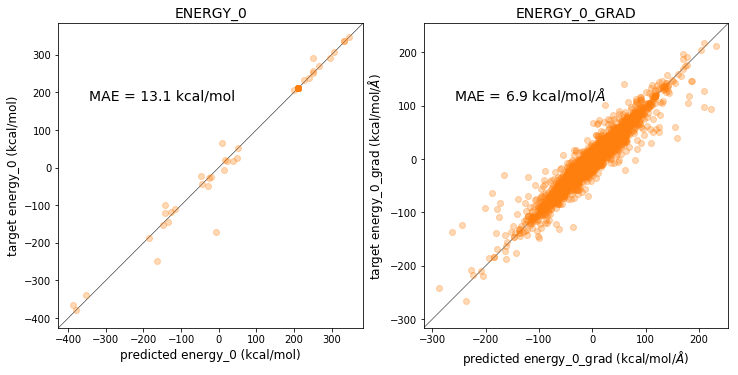

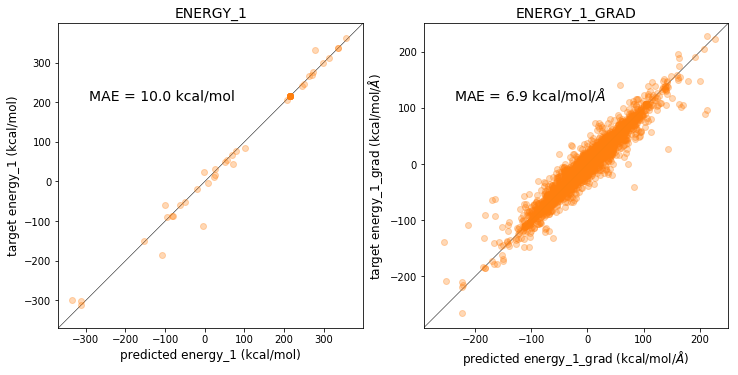

In [13]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)


plot_overall(results, targets)

We can also extract just the AuTopology part of the model, in case we're interested in it:

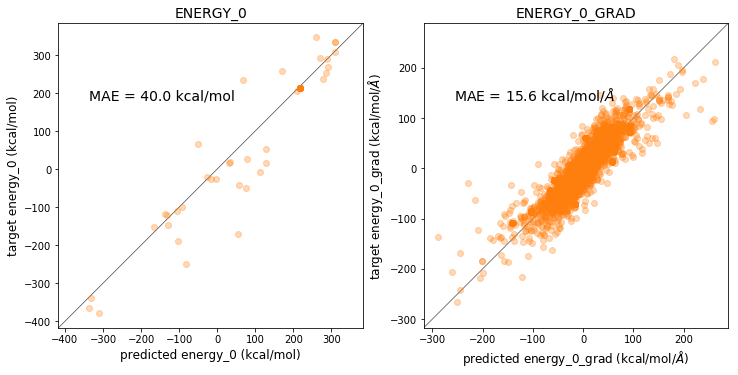

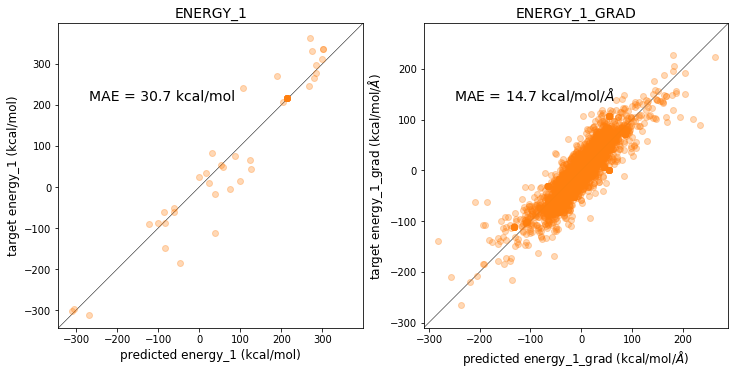

In [14]:
auto_results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE, submodel="autopology")


plot_overall(auto_results, targets)

The results are the same as the results in the first part of the training, as they should be!

## II. Comparison to regular SchNet

Now let's compare to regular SchNet

In [17]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)


    shutil.move(OUTDIR, newpath)

# create a new model and set "model_type" to "SchNet"

new_model = get_model(schnet_params, model_type="SchNet")
trainable_params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]



newest_T = Trainer(
        model_path=OUTDIR,
        model=new_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [18]:
newest_T.train(device=DEVICE, n_epochs=N_EPOCHS)


               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-20 12:58:37 |     1 |     1.000e-04 |  6470.5964 |      12339.2947 |     167.8104 |           34.9210 |     169.3689 |           35.0416 |               0
2019-11-20 12:58:38 |     2 |     1.000e-04 |  6312.6536 |      11738.6459 |     164.0895 |           34.8971 |     160.3407 |           35.0330 |               0
2019-11-20 12:58:39 |     3 |     1.000e-04 |  6202.6848 |      11183.6050 |     159.8104 |           34.8628 |     150.2221 |           35.0156 |               0
2019-11-20 12:58:39 |     4 |     1.000e-04 |  6149.6780 |      10741.4545 |     155.9877 |           34.8106 |     140.9176 |           34.9813 |               0
2019-11-20 12:58:40 |     5 |     1.000e-04 |  6178.6416 |      10546.5304 |     152.5334 |           34.7335 |     135.0103 |           34.9179 |               0
2019-11-20 12:58:41 | 

2019-11-20 12:59:19 |    51 |     1.000e-04 |  1077.3266 |       2434.5435 |      50.4987 |           20.4264 |      47.2467 |           19.9546 |               0
2019-11-20 12:59:20 |    52 |     1.000e-04 |  1081.6333 |       2291.5268 |      39.4060 |           20.6812 |      36.3075 |           20.1250 |               0
2019-11-20 12:59:21 |    53 |     1.000e-04 |  1099.4641 |       2433.1294 |      40.0501 |           20.5569 |      43.2816 |           19.9214 |               0
2019-11-20 12:59:21 |    54 |     1.000e-04 |  1119.3514 |       2276.0403 |      38.4279 |           20.1478 |      38.8858 |           19.6034 |               0
2019-11-20 12:59:22 |    55 |     1.000e-04 |  1028.2397 |       2309.4088 |      48.5503 |           19.8404 |      45.4098 |           19.4081 |               0
2019-11-20 12:59:23 |    56 |     1.000e-04 |  1007.8388 |       2217.6414 |      43.2709 |           20.1182 |      39.8753 |           19.6407 |               0
2019-11-20 12:59:24 | 

2019-11-20 13:00:02 |   102 |     1.000e-04 |   590.9473 |       1452.3628 |      30.1651 |           16.1175 |      28.4082 |           15.9637 |               0
2019-11-20 13:00:03 |   103 |     1.000e-04 |   597.7571 |       1384.0335 |      21.1541 |           16.1401 |      24.1389 |           15.9589 |               0
2019-11-20 13:00:03 |   104 |     1.000e-04 |   595.3017 |       1440.3182 |      26.6891 |           16.1250 |      30.9939 |           15.9506 |               0
2019-11-20 13:00:04 |   105 |     1.000e-04 |   589.5008 |       1353.6482 |      21.8219 |           15.9115 |      22.0790 |           15.7890 |               0
2019-11-20 13:00:05 |   106 |     1.000e-04 |   556.1729 |       1384.7160 |      27.1212 |           15.8338 |      25.6012 |           15.7197 |               0
2019-11-20 13:00:06 |   107 |     1.000e-04 |   554.7828 |       1353.8487 |      25.4410 |           15.8085 |      23.4293 |           15.6771 |               0
2019-11-20 13:00:07 | 

2019-11-20 13:00:44 |   153 |     1.000e-04 |   404.5988 |       1071.6219 |      17.4701 |           13.8225 |      21.2762 |           13.9614 |               0
2019-11-20 13:00:45 |   154 |     1.000e-04 |   407.9911 |       1068.6023 |      17.6077 |           13.7690 |      21.2476 |           13.9320 |               0
2019-11-20 13:00:46 |   155 |     1.000e-04 |   404.4528 |       1043.6649 |      15.1702 |           13.7160 |      17.4123 |           13.8825 |               0
2019-11-20 13:00:47 |   156 |     1.000e-04 |   393.7380 |       1046.4760 |      17.6082 |           13.6894 |      16.7415 |           13.8460 |               0
2019-11-20 13:00:47 |   157 |     1.000e-04 |   387.6785 |       1066.2334 |      20.2996 |           13.6572 |      18.7980 |           13.8136 |               0
2019-11-20 13:00:48 |   158 |     1.000e-04 |   388.4255 |       1062.4456 |      20.5216 |           13.6015 |      19.0708 |           13.7734 |               0
2019-11-20 13:00:49 | 

2019-11-20 13:01:26 |   204 |     1.000e-04 |   316.2550 |        933.0758 |      18.3984 |           12.5032 |      16.9296 |           12.7786 |               0
2019-11-20 13:01:27 |   205 |     1.000e-04 |   318.0843 |        919.3138 |      17.1223 |           12.4967 |      15.4438 |           12.7561 |               0
2019-11-20 13:01:28 |   206 |     1.000e-04 |   316.7453 |        897.7645 |      14.1454 |           12.4888 |      13.2421 |           12.7354 |               0
2019-11-20 13:01:29 |   207 |     1.000e-04 |   314.0063 |        892.3238 |      12.4473 |           12.4851 |      14.7229 |           12.7270 |               0
2019-11-20 13:01:30 |   208 |     1.000e-04 |   314.6999 |        913.6245 |      15.8374 |           12.4762 |      19.0554 |           12.7248 |               0
2019-11-20 13:01:30 |   209 |     1.000e-04 |   320.6779 |        945.8782 |      19.9760 |           12.4520 |      22.9192 |           12.7174 |               0
2019-11-20 13:01:31 | 

2019-11-20 13:02:08 |   255 |     1.000e-04 |   283.3614 |        866.8214 |      19.0495 |           11.6240 |      21.7192 |           11.9513 |               0
2019-11-20 13:02:09 |   256 |     1.000e-04 |   279.9960 |        825.1019 |      13.6704 |           11.5758 |      17.0364 |           11.9272 |               0
2019-11-20 13:02:10 |   257 |     1.000e-04 |   269.4900 |        807.1819 |      11.8878 |           11.5496 |      12.3200 |           11.9041 |               0
2019-11-20 13:02:11 |   258 |     1.000e-04 |   263.2757 |        838.5293 |      17.1141 |           11.5375 |      15.5476 |           11.8807 |               0
2019-11-20 13:02:12 |   259 |     1.000e-04 |   267.4124 |        880.4093 |      22.3665 |           11.5221 |      20.7002 |           11.8531 |               0
2019-11-20 13:02:12 |   260 |     1.000e-04 |   276.4020 |        883.0221 |      23.0048 |           11.5090 |      21.3357 |           11.8282 |               0
2019-11-20 13:02:13 | 

2019-11-20 13:02:51 |   306 |     1.000e-04 |   239.6443 |        831.9558 |      20.5563 |           11.0143 |      22.8766 |           11.3085 |               0
2019-11-20 13:02:51 |   307 |     1.000e-04 |   252.2993 |        850.7948 |      22.7176 |           10.9684 |      24.8003 |           11.3004 |               0
2019-11-20 13:02:52 |   308 |     1.000e-04 |   255.2055 |        792.0990 |      16.4441 |           10.9043 |      19.2116 |           11.2769 |               0
2019-11-20 13:02:53 |   309 |     1.000e-04 |   242.5688 |        748.5818 |      10.6280 |           10.8686 |      11.5789 |           11.2549 |               0
2019-11-20 13:02:54 |   310 |     1.000e-04 |   232.1002 |        789.4462 |      17.5113 |           10.8602 |      16.2926 |           11.2381 |               0
2019-11-20 13:02:55 |   311 |     1.000e-04 |   237.3463 |        843.5230 |      23.7472 |           10.8532 |      22.7750 |           11.2076 |               0
2019-11-20 13:02:56 | 

2019-11-20 13:03:33 |   357 |     1.000e-04 |   228.3640 |        808.0591 |      21.9871 |           10.4808 |      23.8753 |           10.8065 |               0
2019-11-20 13:03:34 |   358 |     1.000e-04 |   229.1567 |        734.6852 |      13.3606 |           10.4181 |      16.2361 |           10.7852 |               0
2019-11-20 13:03:35 |   359 |     1.000e-04 |   214.2518 |        715.7322 |      11.8565 |           10.3898 |      11.1990 |           10.7690 |               0
2019-11-20 13:03:35 |   360 |     1.000e-04 |   207.9574 |        775.8648 |      20.1283 |           10.3787 |      19.5356 |           10.7505 |               0
2019-11-20 13:03:36 |   361 |     1.000e-04 |   217.8462 |        792.5491 |      22.3059 |           10.3689 |      21.6078 |           10.7118 |               0
2019-11-20 13:03:37 |   362 |     1.000e-04 |   224.8517 |        733.9132 |      15.9462 |           10.3749 |      14.6739 |           10.6908 |               0
2019-11-20 13:03:38 | 

2019-11-20 13:04:15 |   408 |     1.000e-04 |   189.9703 |        722.9917 |      17.0997 |            9.9985 |      16.6576 |           10.3769 |               0
2019-11-20 13:04:16 |   409 |     1.000e-04 |   194.6867 |        767.2974 |      22.1379 |            9.9849 |      21.9766 |           10.3439 |               0
2019-11-20 13:04:17 |   410 |     1.000e-04 |   205.2167 |        721.0871 |      17.5958 |            9.9734 |      16.8770 |           10.3147 |               0
2019-11-20 13:04:18 |   411 |     1.000e-04 |   199.5047 |        678.3650 |       9.6327 |           10.0082 |       9.9309 |           10.3389 |               0
2019-11-20 13:04:19 |   412 |     1.000e-04 |   189.6169 |        733.6977 |      16.4530 |           10.0492 |      18.7650 |           10.3723 |               0
2019-11-20 13:04:19 |   413 |     1.000e-04 |   198.9362 |        788.9820 |      23.1415 |           10.0420 |      24.6518 |           10.3737 |               0
2019-11-20 13:04:20 | 

2019-11-20 13:04:58 |   459 |     1.000e-04 |   175.7181 |        691.4831 |      13.4575 |            9.7028 |      15.7367 |           10.0592 |               0
2019-11-20 13:04:59 |   460 |     1.000e-04 |   179.4912 |        762.6295 |      22.5299 |            9.7172 |      23.9211 |           10.0677 |               0
2019-11-20 13:04:59 |   461 |     1.000e-04 |   192.8105 |        730.9313 |      19.5084 |            9.6873 |      20.8973 |           10.0585 |               0
2019-11-20 13:05:00 |   462 |     1.000e-04 |   186.9477 |        658.5337 |       8.7212 |            9.6450 |      11.0724 |           10.0399 |               0
2019-11-20 13:05:01 |   463 |     1.000e-04 |   172.9440 |        690.6841 |      16.0958 |            9.6205 |      15.7736 |           10.0218 |               0
2019-11-20 13:05:02 |   464 |     1.000e-04 |   176.0354 |        740.4114 |      21.8425 |            9.6048 |      21.9170 |            9.9846 |               0
2019-11-20 13:05:03 | 

2019-11-20 13:05:40 |   510 |     1.000e-04 |   161.2459 |        718.1081 |      21.2186 |            9.3323 |      21.4371 |            9.7399 |               0
2019-11-20 13:05:41 |   511 |     1.000e-04 |   172.8026 |        692.2995 |      18.9384 |            9.3083 |      18.7554 |            9.7023 |               0
2019-11-20 13:05:42 |   512 |     1.000e-04 |   171.4385 |        637.5320 |      10.1604 |            9.3180 |       8.9695 |            9.7136 |               0
2019-11-20 13:05:42 |   513 |     1.000e-04 |   159.4533 |        679.2544 |      14.5934 |            9.3683 |      16.4626 |            9.7551 |               0
2019-11-20 13:05:43 |   514 |     1.000e-04 |   165.3423 |        741.0222 |      22.4532 |            9.3811 |      23.5499 |            9.7599 |               0
2019-11-20 13:05:44 |   515 |     1.000e-04 |   177.0546 |        694.9716 |      17.5328 |            9.3564 |      18.7951 |            9.7472 |               0
2019-11-20 13:05:45 | 

2019-11-20 13:06:22 |   561 |     1.000e-04 |   160.8506 |        626.5479 |       8.5651 |            9.0895 |      10.6913 |            9.5226 |               0
2019-11-20 13:06:23 |   562 |     1.000e-04 |   147.8901 |        652.1675 |      15.3981 |            9.0738 |      15.1241 |            9.5105 |               0
2019-11-20 13:06:24 |   563 |     1.000e-04 |   150.1190 |        699.8719 |      21.0326 |            9.0508 |      21.3682 |            9.4799 |               0
2019-11-20 13:06:24 |   564 |     1.000e-04 |   160.5111 |        657.7917 |      16.7762 |            9.0255 |      16.3832 |            9.4488 |               0
2019-11-20 13:06:25 |   565 |     1.000e-04 |   155.0389 |        621.4021 |       8.3973 |            9.0474 |       9.2447 |            9.4715 |               0
2019-11-20 13:06:26 |   566 |     1.000e-04 |   145.7193 |        681.0523 |      17.1749 |            9.0893 |      18.6519 |            9.5049 |               0
2019-11-20 13:06:27 | 

2019-11-20 13:07:04 |   612 |     1.000e-04 |   152.1764 |        667.2886 |      17.5695 |            8.8711 |      18.4513 |            9.3082 |               0
2019-11-20 13:07:05 |   613 |     1.000e-04 |   146.9197 |        608.6761 |       7.8831 |            8.8479 |       9.1407 |            9.3054 |               0
2019-11-20 13:07:05 |   614 |     1.000e-04 |   135.8854 |        649.9838 |      16.8570 |            8.8371 |      16.8812 |            9.2894 |               0
2019-11-20 13:07:06 |   615 |     1.000e-04 |   141.2906 |        679.9363 |      20.4378 |            8.8105 |      20.7734 |            9.2599 |               0
2019-11-20 13:07:07 |   616 |     1.000e-04 |   149.2796 |        627.1980 |      14.2700 |            8.7882 |      13.5513 |            9.2400 |               0
2019-11-20 13:07:08 |   617 |     1.000e-04 |   140.4149 |        615.5553 |       9.1560 |            8.8203 |      10.6926 |            9.2722 |               0
2019-11-20 13:07:09 | 

2019-11-20 13:07:46 |   663 |     1.000e-04 |   142.1199 |        645.6500 |      16.2866 |            8.6589 |      17.1934 |            9.1192 |               0
2019-11-20 13:07:47 |   664 |     1.000e-04 |   135.7391 |        596.8109 |       8.3759 |            8.6400 |       8.5603 |            9.1231 |               0
2019-11-20 13:07:47 |   665 |     1.000e-04 |   126.2350 |        644.3150 |      17.5140 |            8.6293 |      17.7331 |            9.1074 |               0
2019-11-20 13:07:48 |   666 |     1.000e-04 |   133.1688 |        660.9813 |      19.6859 |            8.5980 |      19.9735 |            9.0758 |               0
2019-11-20 13:07:49 |   667 |     1.000e-04 |   138.9784 |        606.3392 |      12.3789 |            8.5800 |      11.4127 |            9.0659 |               0
2019-11-20 13:07:50 |   668 |     1.000e-04 |   128.7646 |        613.0472 |      10.7302 |            8.6262 |      12.3979 |            9.0984 |               0
2019-11-20 13:07:51 | 

2019-11-20 13:08:28 |   714 |     1.000e-04 |   127.6253 |        586.6975 |       8.0878 |            8.4599 |       8.3575 |            8.9622 |               0
2019-11-20 13:08:28 |   715 |     1.000e-04 |   118.1030 |        631.9816 |      17.1827 |            8.4512 |      17.4104 |            8.9515 |               0
2019-11-20 13:08:29 |   716 |     1.000e-04 |   124.6769 |        648.1557 |      19.3404 |            8.4176 |      19.6251 |            8.9192 |               0
2019-11-20 13:08:30 |   717 |     1.000e-04 |   130.2716 |        594.9304 |      11.9055 |            8.3994 |      10.9392 |            8.9124 |               0
2019-11-20 13:08:31 |   718 |     1.000e-04 |   120.1637 |        604.9908 |      11.0366 |            8.4548 |      12.6583 |            8.9433 |               0
2019-11-20 13:08:32 |   719 |     1.000e-04 |   119.5004 |        666.7193 |      19.9684 |            8.4791 |      20.6676 |            8.9552 |               0
2019-11-20 13:08:32 | 

2019-11-20 13:09:09 |   765 |     1.000e-04 |   115.1145 |        641.7362 |      19.4933 |            8.2684 |      19.8431 |            8.7916 |               0
2019-11-20 13:09:10 |   766 |     1.000e-04 |   122.9188 |        593.6403 |      13.3223 |            8.2452 |      12.6710 |            8.7761 |               0
2019-11-20 13:09:11 |   767 |     1.000e-04 |   114.6478 |        587.9163 |       9.5059 |            8.2955 |      10.9126 |            8.8039 |               0
2019-11-20 13:09:12 |   768 |     1.000e-04 |   110.8932 |        649.8107 |      19.0069 |            8.3288 |      19.6727 |            8.8218 |               0
2019-11-20 13:09:13 |   769 |     1.000e-04 |   122.1735 |        637.4835 |      17.8923 |            8.3101 |      18.3413 |            8.8040 |               0
2019-11-20 13:09:14 |   770 |     1.000e-04 |   121.0757 |        578.3917 |       7.7776 |            8.2877 |       8.8810 |            8.8012 |               0
2019-11-20 13:09:14 | 

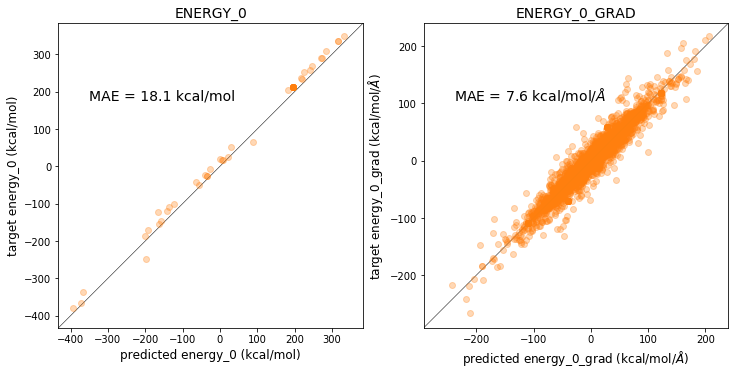

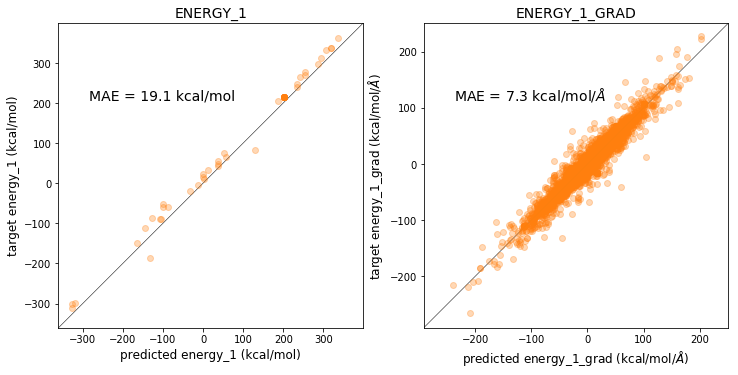

In [19]:
new_results, new_targets, new_val_loss = evaluate(new_model, test_loader, loss_fn, device=DEVICE)

plot_overall(new_results, new_targets)

The AuTopology + SchNet results are quite comparable to the SchNet results. This is great news, because it means we can get the same accuracy but with much of the answer coming from well-behaved functional forms for the energy. SchNet + AuTopology will therefore keep the molecule together during an MD run, even if there's a new geometry that hasn't been seen before. This means that the combination of SchNet + AuTopology should be more stable in MD runs than regular SchNet.

# III. Non-trainable AuTopology

Lastly, we can compare to AuTopology + SchNet, where the AuTopology parameters can't be learned. To do so we set `trainable_prior` to False. 

We also change `bond_terms` to `harmonic`, because there is a baseline spring constant to which learned parameters are added. That means that even if we don't learn any parameters, we'd still get a spring constant that keeps the molecule together. The `morse` option, on the other hand, doesn't have such as base-line spring constant, so it wouldn't help us!

In [23]:
last_params = copy.deepcopy(params)
last_params["autopology_params"]["trainble_prior"] = False
last_params["autopology_params"]["bond_terms"] = ["harmonic"]

last_model = get_model(last_params, model_type="SchNetAuTopology", add_autopology=True, add_schnet=True)



In [29]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)


    shutil.move(OUTDIR, newpath)


trainable_params = filter(lambda p: p.requires_grad, last_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

last_T = Trainer(
        model_path=OUTDIR,
        model=last_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [30]:
last_T.train(device=DEVICE, n_epochs=200)


               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-20 13:11:43 |     1 |     1.000e-04 |  4784.6905 |       8581.4849 |     108.7785 |           36.9249 |     106.1650 |           38.0861 |               0
2019-11-20 13:11:45 |     2 |     1.000e-04 |  4296.0665 |       7504.9068 |      84.3590 |           36.2335 |      95.3972 |           37.3361 |               0
2019-11-20 13:11:47 |     3 |     1.000e-04 |  4241.5591 |       7164.7670 |      85.4789 |           35.8398 |      93.4517 |           37.2186 |               0
2019-11-20 13:11:48 |     4 |     1.000e-04 |  3961.5571 |       6816.8683 |      73.4909 |           35.7233 |      88.0652 |           36.9055 |               0
2019-11-20 13:11:50 |     5 |     1.000e-04 |  3831.0018 |       6578.1528 |      71.1309 |           35.4045 |      80.4649 |           36.4023 |               0
2019-11-20 13:11:52 | 

2019-11-20 13:13:10 |    51 |     1.000e-04 |  1220.9035 |       2430.1379 |      38.6904 |           19.3704 |      41.3916 |           19.9263 |               0
2019-11-20 13:13:12 |    52 |     1.000e-04 |  1145.4622 |       2239.1115 |      27.7624 |           19.2571 |      28.3377 |           19.7679 |               0
2019-11-20 13:13:14 |    53 |     1.000e-04 |  1069.5179 |       2223.0301 |      28.5043 |           19.1007 |      28.4972 |           19.6069 |               0
2019-11-20 13:13:15 |    54 |     1.000e-04 |  1077.1570 |       2208.2613 |      29.0095 |           18.9195 |      29.3373 |           19.4592 |               0
2019-11-20 13:13:17 |    55 |     1.000e-04 |  1111.3361 |       2146.1062 |      28.3975 |           18.7485 |      26.0022 |           19.3151 |               0
2019-11-20 13:13:19 |    56 |     1.000e-04 |  1129.9296 |       2196.5773 |      32.8371 |           18.6176 |      32.0542 |           19.1949 |               0
2019-11-20 13:13:21 | 

2019-11-20 13:14:37 |   102 |     1.000e-04 |   663.9922 |       1608.1668 |      25.8032 |           15.3379 |      24.1085 |           15.8229 |               0
2019-11-20 13:14:39 |   103 |     1.000e-04 |   685.8287 |       1552.0978 |      22.7248 |           15.2708 |      19.8711 |           15.7712 |               0
2019-11-20 13:14:41 |   104 |     1.000e-04 |   699.9265 |       1577.1373 |      26.1261 |           15.2126 |      25.6359 |           15.7256 |               0
2019-11-20 13:14:42 |   105 |     1.000e-04 |   720.1988 |       1736.6470 |      38.5779 |           15.1793 |      38.0136 |           15.6900 |               0
2019-11-20 13:14:44 |   106 |     1.000e-04 |   751.7970 |       1868.4738 |      44.6467 |           15.1483 |      46.7117 |           15.6440 |               0
2019-11-20 13:14:46 |   107 |     1.000e-04 |   758.2999 |       1776.6903 |      39.5817 |           15.1057 |      42.7052 |           15.5829 |               0
2019-11-20 13:14:47 | 

2019-11-20 13:16:04 |   153 |     1.000e-04 |   482.0046 |       1377.0784 |      28.4813 |           13.7378 |      27.1389 |           14.2550 |               0
2019-11-20 13:16:06 |   154 |     1.000e-04 |   503.4067 |       1298.3041 |      22.1371 |           13.6825 |      20.9019 |           14.2100 |               0
2019-11-20 13:16:07 |   155 |     1.000e-04 |   505.6968 |       1253.3707 |      20.8992 |           13.6440 |      20.0906 |           14.1675 |               0
2019-11-20 13:16:09 |   156 |     1.000e-04 |   514.2469 |       1384.0803 |      32.3221 |           13.6254 |      33.2567 |           14.1506 |               0
2019-11-20 13:16:11 |   157 |     1.000e-04 |   545.7583 |       1517.8361 |      40.0086 |           13.6016 |      43.0425 |           14.1232 |               0
2019-11-20 13:16:12 |   158 |     1.000e-04 |   561.5823 |       1453.9408 |      36.6037 |           13.5713 |      39.9633 |           14.0790 |               0
2019-11-20 13:16:14 | 

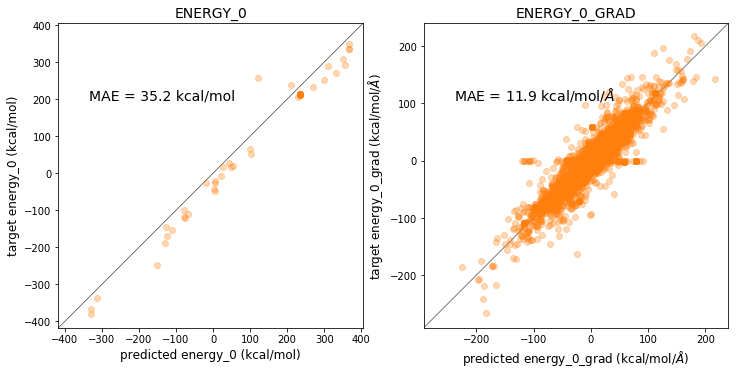

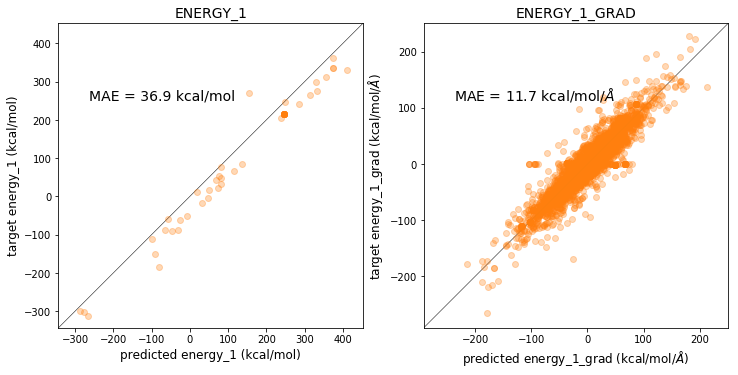

In [31]:
last_results, last_targets, last_vall_loss = evaluate(last_model, test_loader, loss_fn, device=DEVICE)

plot_overall(last_results, last_targets)

The classical priors for the gradients are very loosely correlated with the actual results:

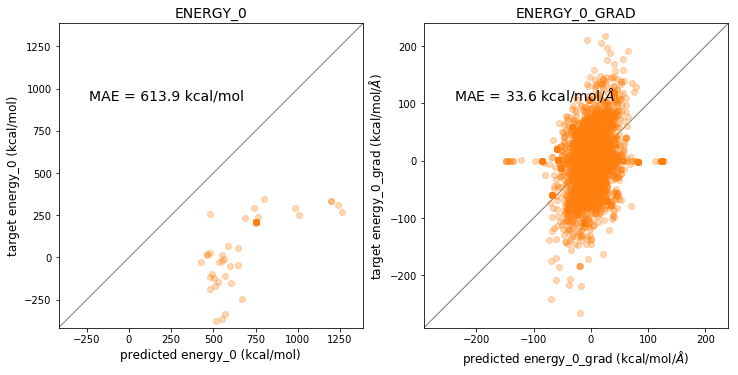

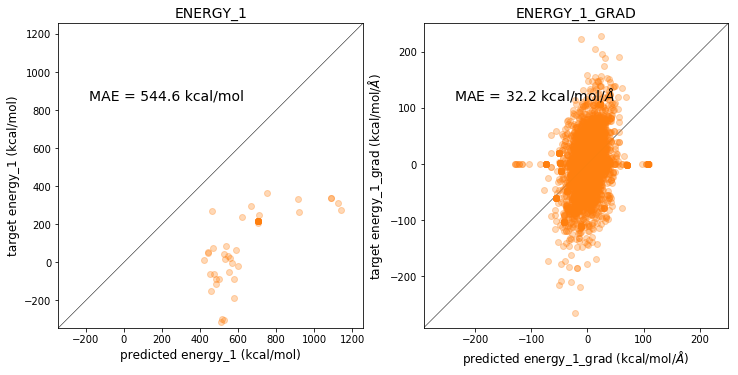

In [32]:
auto_results, targets, val_loss = evaluate(last_model, test_loader, loss_fn, device=DEVICE, submodel="autopology")


plot_overall(auto_results, targets)